In [1]:
import uxarray
import logging
import numpy as np
import healpix as hp
from scipy.spatial import KDTree
import xarray as xr
import zarr
import easygems.healpix as egh
import glob
import math
from numcodecs import Blosc

In [2]:
def setup_dask():
    import dask
    import dask.distributed

    dask.config.set(**{"array.slicing.split_large_chunks": False})
    dask.config.set(**{"distributed.scheduler.worker-saturation": 0.8})
    dask.config.set(**{"temporary-directory": "/scratch/k/k202134/dask-spill/"})
    dask.config.config.get("distributed").get("dashboard").update(
        {"link": "{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status"}
    )

    cluster = dask.distributed.LocalCluster(
        n_workers=4, threads_per_worker=1, memory_limit="10GB"
    )
    client = dask.distributed.Client(cluster)  # start distributed scheduler locally.
    logging.debug(client)


setup_dask()

In [3]:
def open_with_uxarray(icon_file, grid_uri=None, **kwargs):
    import xarray as xr

    is_list = False
    if isinstance(icon_file, list):
        is_list = True
        uri = icon_file[0]
    else:
        uri = icon_file

    if grid_uri is None:
        grid_uri = xr.open_dataset(uri).attrs.get("grid_file_uri", None)
        if grid_uri is not None:
            grid_uri = grid_uri.replace(
                "http://icon-downloads.mpimet.mpg.de/", "/pool/data/ICON/"
            )
        else:
            raise Exception(
                "Could not find a valid grid file uri - neither from argument, nor from 'grid_file_uri' property of the icon file"
            )
    logging.debug(f"{grid_uri=}")
    if is_list:
        return uxarray.open_mfdataset(grid_uri, icon_file, **kwargs)
    else:
        return uxarray.open_dataset(grid_uri, icon_file, **kwargs)

In [4]:
def get_nn_indices(var, order):
    """
    var: variable with lon and lat attributes (2d slice)
    lonlat: coordinates at which to get the data
    returns: values on the points in the plot grid.
    """
    var_xyz = lonlat_to_xyz(lon=var.uxgrid.face_lon, lat=var.uxgrid.face_lat)
    tree = KDTree(var_xyz)
    hp_xyz = get_xyz_from_hp_order(order)
    distances, indices = tree.query(np.array(hp_xyz).T)
    return indices


def get_xyz_from_hp_order(order):
    nside = hp.order2nside(order)
    npix = hp.nside2npix(nside)
    pixels = np.arange(npix)
    return hp.pix2vec(nside=nside, ipix=pixels, nest=True)


def lonlat_to_xyz(lon, lat):
    """
    lon: longitude in degree E
    lat: latitude in degree N
    returns numpy array (3, len (lon)) with coordinates on unit sphere.
    """

    return np.array(
        (
            np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat)),
            np.sin(np.deg2rad(lon)) * np.cos(np.deg2rad(lat)),
            np.sin(np.deg2rad(lat)),
        )
    ).T

In [5]:
def create_outds(infile, indices, timechunk, order, ignore_vars=list()):
    infile_cleaned = infile.drop_vars(x for x in ignore_vars if x in infile.variables)
    outds = xr.Dataset(
        {
            v: infile_cleaned[v].isel(n_face=indices)
            for v in infile_cleaned.data_vars
            if v not in ignore_vars
        }
        | {
            "crs": xr.DataArray(
                data=[np.nan],
                attrs=dict(
                    grid_mapping_name="healpix",
                    healpix_nside=hp.order2nside(order),
                    healpix_order="nest",
                ),
                dims=dict(crs=[1]),
            )
        }
    )
    prune_attrs(outds)
    return outds


def get_encodings(outds, order, timechunk):
    encodings = {
        var: dict(
            dtype="<f4",
            chunks=get_chunksizes(
                outds=outds, var=var, order=order, timechunk=timechunk
            ),
            compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.BITSHUFFLE),
        )
        for var in outds
    }
    return encodings


def get_chunksizes(outds, var, order, timechunk):
    var_shape = outds[var].shape
    timechunk = min(timechunk, var_shape[0])
    spacechunk = compute_chunksize(order=order)
    if len(var_shape) == 1:
        return min(var_shape[0], 1024**2)
    elif len(var_shape) == 2:
        chunksizes = (timechunk, spacechunk)
        return chunksizes
    elif len(var_shape) == 3:
        levchunk = choose_levchunk(var_shape[1])
        if (levchunk * spacechunk) > 4**9:
            spacechunk = 4 ** round(0.5 * math.log2(spacechunk / levchunk))
        chunksizes = (timechunk, levchunk, spacechunk)
        return chunksizes
    else:
        raise Exception(
            "can't compute chunking for variables that have more than 3 dimensions!"
        )


def compute_chunksize(order):
    start_split = 9
    if order < start_split:
        return 12 * 4**order
    elif order == start_split:
        return 3 * 4**order
    else:
        return 4**start_split


def choose_levchunk(levels, default=12, maxlevchunk=20):
    if isPrime(levels) and levels < maxlevchunk:
        return int(levels)
    for levchunk in range(default, 2, -1):
        if res := levels % levchunk:
            logging.debug(f"residual for level chunk {levchunk} is {res}")
        else:
            logging.debug(f"chosing {levchunk} as level chunk")
            return levchunk
    return default


def isPrime(number):
    limit = int(number / 2)  # limit indicates how many times we need to run the loop
    flag = 0  # to keep track whether the number is prime or not
    if number == 0 or number == 1:
        print(f"The Given Number {number} is Not Prime")
        return
    for i in range(2, limit + 1):
        if number % i == 0:
            flag = 1
            break
    if flag == 0:
        return True
    else:
        return False


def prune_attrs(outds):
    keys_to_delete = ["number_of_grid_in_reference", "CDI_grid_type"]
    for v in outds.data_vars:
        for k in keys_to_delete:
            try:
                del outds[v].attrs[k]
            except KeyError:
                pass


def to_zarr_store(path, outds, timechunk, order):
    store = zarr.storage.DirectoryStore(
        path, normalize_keys=False, dimension_separator="/"
    )
    outds.to_zarr(
        store, encoding=get_encodings(outds=outds, timechunk=timechunk, order=order)
    )  # , compute=False
    store.close()

In [6]:
timechunk = 8
order = 9
uri = "/fastdata/ka1081/DYAMOND_WINTER/MPIM-DWD-DKRZ/ICON-SAP-5km/DW-ATM/atmos/15min/tas/dpp0014/2d/gn/tas_15min_ICON-SAP-5km_DW-ATM_dpp0014_2d_gn_20200124000000-20200124234500.nc"
uri = sorted(
    glob.glob(
        "/fastdata/ka1081/DYAMOND_WINTER/MPIM-DWD-DKRZ/ICON-SAP-5km/DW-ATM/atmos/15min/tas/dpp0014/2d/gn/tas_15min_ICON-SAP-5km_DW-ATM_dpp0014_2d_gn_*.nc"
    )
)[:2]

In [7]:
%%time
infile = open_with_uxarray(uri, chunks=dict(time=timechunk))

DEBUG:uxarray:starting to convert ICON grid
DEBUG:uxarray:done transforming ICON grid
DEBUG:uxarray:mapping dimensions
DEBUG:uxarray:swapping dimensions
DEBUG:uxarray:_map_dims_to_ugrid returning
DEBUG:uxarray:calling xarray init.


CPU times: user 9.63 s, sys: 7.38 s, total: 17 s
Wall time: 16.7 s


In [8]:
%%time 
indices = get_nn_indices(infile.tas, order=order)

CPU times: user 11.6 s, sys: 1.3 s, total: 12.9 s
Wall time: 12.6 s


In [9]:
%%time 
outds = create_outds(infile, indices, timechunk, order)

DEBUG:uxarray:calling xarray init.


CPU times: user 8.61 s, sys: 1.47 s, total: 10.1 s
Wall time: 10 s


In [10]:
%%time

filename = "/scratch/k/k202134/test.zarr"
! touch {filename}
! rm -rf {filename}
to_zarr_store("/scratch/k/k202134/test.zarr", outds, timechunk=timechunk, order=order)

/home/k/k202134/python-envs/py_312/lib/python3.12/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 24.01 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 676 ms, sys: 355 ms, total: 1.03 s
Wall time: 23.9 s


In [11]:
ds = xr.open_dataset(filename, engine="zarr")
ds

<xarray.Dataset> Size: 2GB
Dimensions:  (crs: 1, time: 192, n_face: 3145728)
Coordinates:
  * crs      (crs) float64 8B nan
  * time     (time) datetime64[ns] 2kB 2020-01-20 ... 2020-01-21T23:45:00
Dimensions without coordinates: n_face
Data variables:
    tas      (time, n_face) float32 2GB ...

<Figure size 640x480 with 0 Axes>

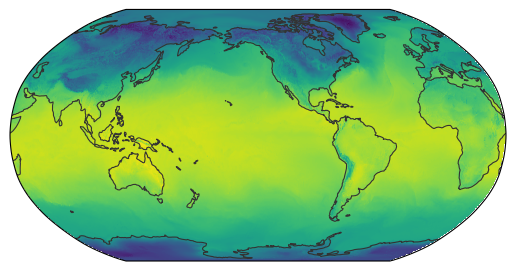

In [12]:
egh.healpix_show(ds.tas.isel(time=8))

In [13]:
! module load netcdf-c ;  ncdump -hs file://{filename}#mode=zarr,file

netcdf test {
dimensions:
	crs = 1 ;
	time = 192 ;
	n_face = 3145728 ;
variables:
	double crs(crs) ;
		crs:grid_mapping_name = "healpix" ;
		crs:healpix_nside = 512 ;
		crs:healpix_order = "nest" ;
		crs:_Storage = "chunked" ;
		crs:_ChunkSizes = 1 ;
		crs:_Filter = "32001,0,0,0,0,5,1,1" ;
		crs:_Codecs = "[{\"blocksize\": 0, \"clevel\": 5, \"cname\": \"lz4\", \"id\": \"blosc\", \"shuffle\": 1}]" ;
		crs:_Endianness = "little" ;
	float tas(time, n_face) ;
		tas:long_name = "temperature in 2m" ;
		tas:origin = "tas" ;
		tas:param = "0.0.0" ;
		tas:standard_name = "surface_air_temperature" ;
		tas:units = "K" ;
		tas:_Storage = "chunked" ;
		tas:_ChunkSizes = 8, 786432 ;
		tas:_Filter = "32001,0,0,0,0,5,2,5" ;
		tas:_Codecs = "[{\"blocksize\": 0, \"clevel\": 5, \"cname\": \"zstd\", \"id\": \"blosc\", \"shuffle\": 2}]" ;
		tas:_Endianness = "little" ;
	double time(time) ;
		time:axis = "T" ;
		time:calendar = "proleptic_gregorian" ;
		time:standard_name = "time" ;
		time:units = "hours si

In [14]:
! module load cdo ; which cdo ;cdo -infon -select,timestep=1/20 file://{filename}#mode=zarr,file

/sw/spack-levante/cdo-2.2.2-4z4icb/bin/cdo
cdo(1) select: Process started
    -1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter name
     1 : 2020-01-20 00:00:00       0  3145728       0 :      0.0000      0.0000      0.0000 : tas           
     2 : 2020-01-20 00:15:00       0  3145728       0 :      223.13      285.74      307.47 : tas           
     3 : 2020-01-20 00:30:00       0  3145728       0 :      222.48      285.74      307.32 : tas           
     4 : 2020-01-20 00:45:00       0  3145728       0 :      222.57      285.76      307.99 : tas           
     5 : 2020-01-20 01:00:00       0  3145728       0 :      222.81      285.77      308.32 : tas           
     6 : 2020-01-20 01:15:00       0  3145728       0 :      223.00      285.77      308.71 : tas           
     7 : 2020-01-20 01:30:00       0  3145728       0 :      223.18      285.78      309.12 : tas           
     8 : 2020-01-20 01:45:00       0  3145728       0 

In [15]:
hus_file = "/fastdata/ka1081/DYAMOND_WINTER/MPIM-DWD-DKRZ/ICON-SAP-5km/DW-ATM/atmos/6hr/hus/dpp0014/ml/gn/hus_6hr_ICON-SAP-5km_DW-ATM_dpp0014_ml_gn_20200222000000-20200222180000.nc"
infile2 = open_with_uxarray(hus_file, chunks=dict(time=timechunk, height=10))

# infile2 = open_with_uxarray("/scratch/k/k202134/hus.nc", chunks=dict(time=timechunk))
order = 8
infile2

DEBUG:uxarray:starting to convert ICON grid
DEBUG:uxarray:done transforming ICON grid
DEBUG:uxarray:mapping dimensions
DEBUG:uxarray:swapping dimensions
DEBUG:uxarray:_map_dims_to_ugrid returning
DEBUG:uxarray:calling xarray init.


<xarray.UxDataset> Size: 30GB
Dimensions:      (time: 4, height: 90, bnds: 2, n_face: 20971520)
Coordinates:
  * time         (time) datetime64[ns] 32B 2020-02-22 ... 2020-02-22T18:00:00
  * height       (height) float64 720B 1.0 2.0 3.0 4.0 ... 87.0 88.0 89.0 90.0
Dimensions without coordinates: bnds, n_face
Data variables:
    height_bnds  (height, bnds) float64 1kB dask.array<chunksize=(10, 2), meta=np.ndarray>
    hus          (time, height, n_face) float32 30GB dask.array<chunksize=(4, 10, 20971520), meta=np.ndarray>

In [16]:
%%time 
indices2 = get_nn_indices(infile2.hus, order=order)

CPU times: user 9.82 s, sys: 1.07 s, total: 10.9 s
Wall time: 10.7 s


In [17]:
%%time 

outds2 = create_outds(
    infile2,
    indices2,
    timechunk,
    order,
    ignore_vars=["height_bnds", "clon_bnds", "clat_bnds", "clon", "clat"],
)

DEBUG:uxarray:calling xarray init.


CPU times: user 2.9 s, sys: 454 ms, total: 3.35 s
Wall time: 3.48 s


In [18]:
infile2

<xarray.UxDataset> Size: 30GB
Dimensions:      (time: 4, height: 90, bnds: 2, n_face: 20971520)
Coordinates:
  * time         (time) datetime64[ns] 32B 2020-02-22 ... 2020-02-22T18:00:00
  * height       (height) float64 720B 1.0 2.0 3.0 4.0 ... 87.0 88.0 89.0 90.0
Dimensions without coordinates: bnds, n_face
Data variables:
    height_bnds  (height, bnds) float64 1kB dask.array<chunksize=(10, 2), meta=np.ndarray>
    hus          (time, height, n_face) float32 30GB dask.array<chunksize=(4, 10, 20971520), meta=np.ndarray>

In [19]:
outds2

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 4, height: 90, n_face: 786432, crs: 1)
Coordinates:
  * time     (time) datetime64[ns] 32B 2020-02-22 ... 2020-02-22T18:00:00
  * height   (height) float64 720B 1.0 2.0 3.0 4.0 5.0 ... 87.0 88.0 89.0 90.0
  * crs      (crs) float64 8B nan
Dimensions without coordinates: n_face
Data variables:
    hus      (time, height, n_face) float32 1GB dask.array<chunksize=(4, 10, 786432), meta=np.ndarray>

In [20]:
get_encodings(outds=outds2, timechunk=timechunk, order=order)

{'hus': {'dtype': '<f4',
  'chunks': (4, 10, 65536),
  'compressor': Blosc(cname='zstd', clevel=5, shuffle=BITSHUFFLE, blocksize=0)}}

In [21]:
%%time

filename2 = "/scratch/k/k202134/test2.zarr"
! touch {filename2}
! rm -rf {filename2}
to_zarr_store(filename2, outds2, timechunk=timechunk, order=order)

CPU times: user 1.11 s, sys: 404 ms, total: 1.52 s
Wall time: 47.3 s


In [22]:
! module load netcdf-c ;  ncdump -hs file://{filename2}#mode=zarr,file

netcdf test2 {
dimensions:
	crs = 1 ;
	height = 90 ;
	time = 4 ;
	n_face = 786432 ;
variables:
	double crs(crs) ;
		crs:grid_mapping_name = "healpix" ;
		crs:healpix_nside = 256 ;
		crs:healpix_order = "nest" ;
		crs:_Storage = "chunked" ;
		crs:_ChunkSizes = 1 ;
		crs:_Filter = "32001,0,0,0,0,5,1,1" ;
		crs:_Codecs = "[{\"blocksize\": 0, \"clevel\": 5, \"cname\": \"lz4\", \"id\": \"blosc\", \"shuffle\": 1}]" ;
		crs:_Endianness = "little" ;
	double height(height) ;
		height:axis = "Z" ;
		height:bounds = "height_bnds" ;
		height:long_name = "generalized_height" ;
		height:standard_name = "height" ;
		height:_Storage = "chunked" ;
		height:_ChunkSizes = 90 ;
		height:_Filter = "32001,0,0,0,0,5,1,1" ;
		height:_Codecs = "[{\"blocksize\": 0, \"clevel\": 5, \"cname\": \"lz4\", \"id\": \"blosc\", \"shuffle\": 1}]" ;
		height:_Endianness = "little" ;
	float hus(time, height, n_face) ;
		hus:long_name = "Specific humidity" ;
		hus:origin = "hus" ;
		hus:param = "0.1.0" ;
		hus:standard_name 